# Compare results from Galaxy Builder to Hart (2017)

Ross Hart fit a relationship between GZ2 debiased morpholocal votes and the length-weighted, dominant chirality only pitch angle reported by [SpArcFiRe](http://sparcfire.ics.uci.edu/). In this notebook we compare the length-weighted galaxy builder pitch angles to that relationship.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display
from gzbuilder_analysis.spirals.oo import *
import lib.galaxy_utilities as gu
from tqdm import tqdm
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=UserWarning)

Load in a list of available subject ids and the [GZ2 debiased vote counts](https://data.galaxyzoo.org/).

In [3]:
aggregation_results = pd.read_pickle('lib/aggregation_results.pickle')
sid_list = aggregation_results.index.values
df_gz2 = pd.read_csv(
  '../source_files/gz2_hart16.csv'
).set_index('dr7objid')

Define some helper functions for feature extraction

In [4]:
def get_nsaid(sid):
  return np.int64(gu.metadata['NSA id'].loc[sid])

def get_dr7objid(sid):
  return np.int64(gu.metadata['SDSS dr7 id'].loc[sid])

def hart_wavg(gal):
  return (np.hstack((
    gal['t10_arms_winding_a28_tight_debiased'],
    gal['t10_arms_winding_a29_medium_debiased'],
    gal['t10_arms_winding_a30_loose_debiased'],
  )) * (np.arange(3) + 1)).sum()

def hart_mavg(gal):
  return (np.hstack((
    gal['t11_arms_number_a31_1_debiased'],
    gal['t11_arms_number_a32_2_debiased'],
    gal['t11_arms_number_a33_3_debiased'],
    gal['t11_arms_number_a34_4_debiased'],
    gal['t11_arms_number_a36_more_than_4_debiased'],
  )) * (np.arange(5) + 1)).sum()


def hart_pa(wavg, mavg):
  return 6.37 * wavg + 1.30 * mavg + 4.34

def get_hart_params(row):
  gal = df_gz2.query('dr7objid == {dr7objid}'.format(**row.to_dict())).iloc[0]
  wavg, mavg = hart_wavg(gal), hart_mavg(gal)
  if wavg == 0.0 or mavg == 0.0:
    return np.nan, wavg, mavg
  return hart_pa(wavg, mavg), wavg, mavg

Generate a DataFrame containing GZB pitch angles, NSA IDs, SDSS DR7 IDs, and use it to calculate Hart (2017) pitch angles from the GZ2 data export. Then add a column with the pitch angle difference and an error approximation.

In [5]:
pas = []
with tqdm(enumerate(sid_list)) as bar:
  for i, sid in bar:
    arms = aggregation_results.Arms.loc[sid]
    if len(arms) == 0:
      pas.append((np.nan, np.nan))
    else:
      pas.append(arms[0].get_parent().get_pitch_angle(arms))
pa_df = pd.DataFrame(pas, columns=('pa', 'sigma_pa'), index=sid_list).dropna();

296it [00:00, 8295.29it/s]


In [6]:
pa_df['NSAID'] = pa_df.index.to_series().apply(get_nsaid)
pa_df['dr7objid'] = pa_df.index.to_series().apply(get_dr7objid)

hart_df = pa_df.apply(get_hart_params, axis=1, result_type='expand').rename(columns={0: 'hart_pa', 1: 'wavg', 2:'mavg'})
pa_df = pd.concat((pa_df, hart_df), axis=1)

pa_df['pa_diff'] = pa_df['pa'] - pa_df['hart_pa']
pa_df['pa_diff_err'] = np.sqrt(pa_df['sigma_pa']**2 + 7**2)

What do the distributions of pitch angles look like? Can the difference between the two be put down to error?

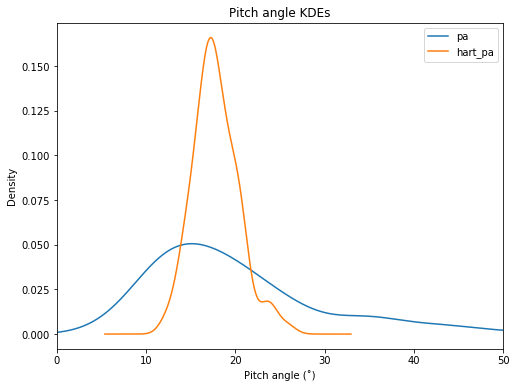

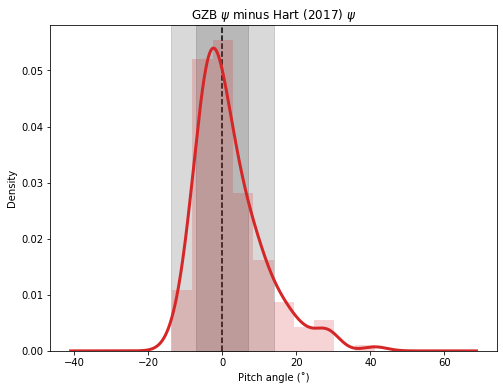

In [7]:
plt.figure(figsize=(8, 6))
pa_df[['pa', 'hart_pa']].plot.kde(ax=plt.gca())
plt.xlim(0, 50)
plt.title('Pitch angle KDEs')
plt.xlabel('Pitch angle (˚)')

plt.figure(figsize=(8, 6))
plt.title('GZB $\psi$ minus Hart (2017) $\psi$')
pa_df['pa_diff'].plot.hist(density=True, alpha=0.2, zorder=10, color='C3')
pa_df['pa_diff'].plot.kde(lw=3, zorder=10, c='C3')
ylims = plt.gca().get_ylim()
plt.fill_betweenx(np.linspace(0, ylims[1]), -7, 7, color='k', alpha=0.15, zorder=1)
plt.fill_betweenx(np.linspace(0, ylims[1]), -14, 14, color='k', alpha=0.15, zorder=1)
plt.vlines(0, *ylims, linestyles='dashed')
plt.ylim(*ylims)
plt.xlabel('Pitch angle (˚)')
plt.savefig(
  'method-paper-plots/gzb-hart-comparison.pdf',
  bbox_inches='tight'
);

## Statistical model

We can compare the possible range of pitch angles in (0, 90) to a Beta distribtion where $\psi \sim 90 \times Beta(a, b)$, and fit for $a$ and $b$:

In [8]:
import scipy.stats as st

/Users/tlingard/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


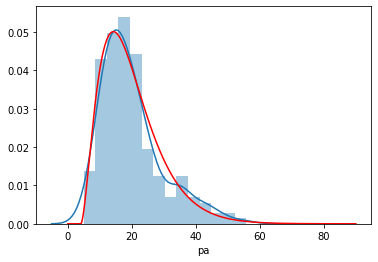

In [12]:
X = (pa_df['pa'] / 90).dropna()
sns.distplot(pa_df['pa'])
p = st.beta.fit(X, loc=0, scale=1)
foo = np.linspace(0, 1, 10000)
plt.plot(foo * 90, st.beta(*p).pdf(foo) / 90, c='r')